## Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import numpy as np
import matplotlib.pyplot as plt

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


## Single-Agent Representations

### Load Single-Agent activations

In [2]:
import os
import sys

path = os.path.join(os.getcwd(), "datasets/rnn_grid_cells")
sys.path.append(path)
from neurometry.datasets.load_rnn_grid_cells import load_activations

2024-05-16 16:56:39.579078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 16:56:40.235490: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
parent_dir = path
single_model_folder = "Single agent path integration/Seed 1 weight decay 1e-06"
single_model_parameters = "steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_1e-06"


single_file_path = os.path.join(
    parent_dir, single_model_folder, single_model_parameters
)


epochs = list(range(0, 90, 5))

(
    single_agent_activations,
    single_agent_rate_maps,
    single_agent_state_points,
) = load_activations(epochs, single_file_path, version="single", verbose=True)

Epoch 0 found.
Epoch 5 found.
Epoch 10 found.
Epoch 15 found.
Epoch 20 found.
Epoch 25 found.
Epoch 30 found.
Epoch 35 found.
Epoch 40 found.
Epoch 45 found.
Epoch 50 found.
Epoch 55 found.
Epoch 60 found.
Epoch 65 found.
Epoch 70 found.
Epoch 75 found.
Epoch 80 found.
Epoch 85 found.
Loaded epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85] of single agent model.
activations has shape (4096, 20, 20, 50). There are 4096 grid cells with 20 x 20 environment resolution, averaged over 50 trajectories.
state_points has shape (4096, 20000). There are 20000 data points in the 4096-dimensional state space.
rate_maps has shape (4096, 400). There are 400 data points averaged over 50 trajectories in the 4096-dimensional state space.


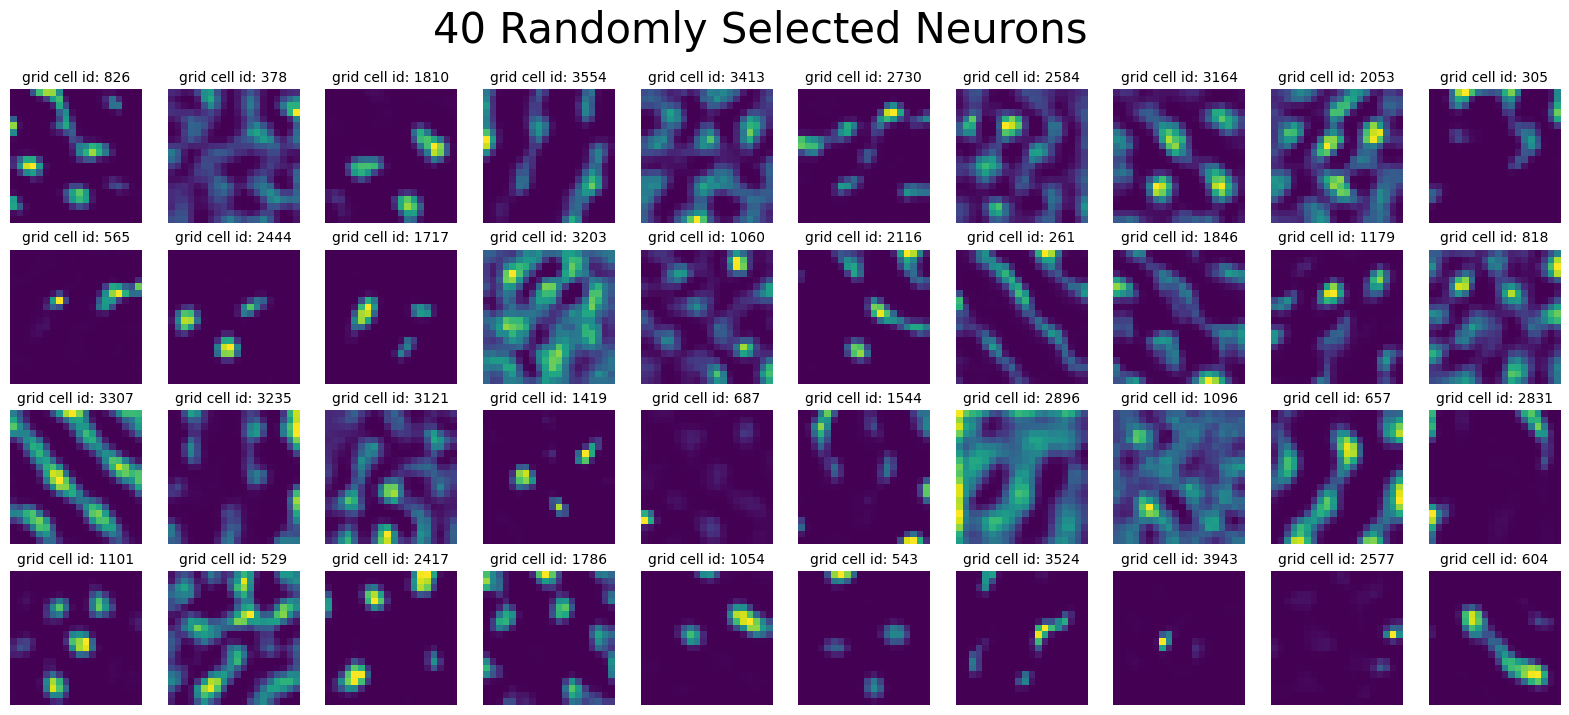

In [4]:
from neurometry.datasets.load_rnn_grid_cells import plot_rate_map


num_plots = 40
plot_rate_map(
    None,
    num_plots,
    single_agent_activations[-1],
    title=f"{num_plots} Randomly Selected Neurons",
)

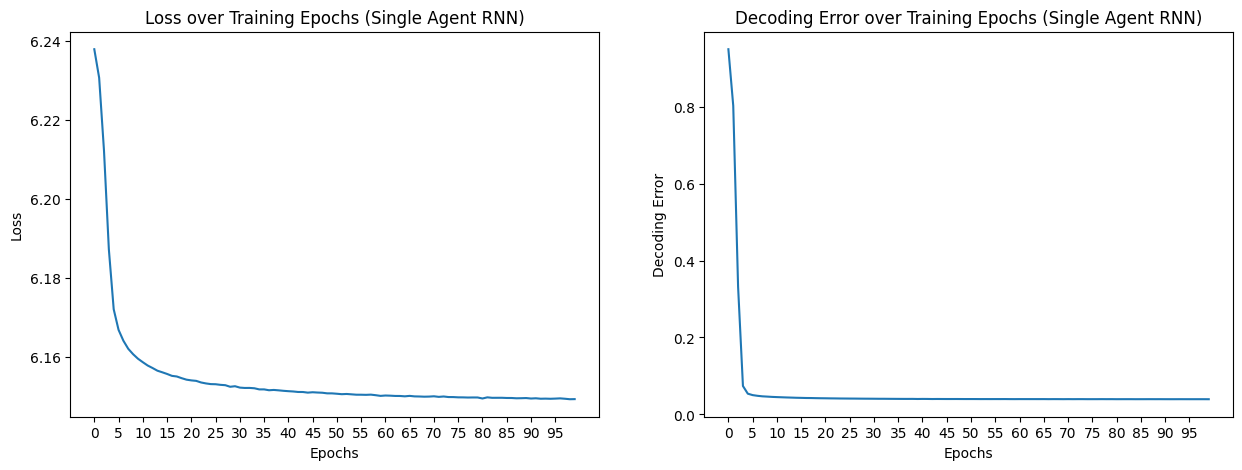

In [5]:
loss_path = os.path.join(
    parent_dir, single_model_folder, single_model_parameters, "loss.npy"
)
loss = np.load(loss_path)
loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)

decoding_error_path = os.path.join(
    parent_dir, single_model_folder, single_model_parameters, "decoding_error.npy"
)

decoding_error = np.load(decoding_error_path)
decoding_error_aggregated = np.mean(decoding_error.reshape(-1, 1000), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

epochs = list(range(0, 100))
axs[0].plot(epochs, loss_aggregated)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Training Epochs (Single Agent RNN)")

axs[0].set_xticks(epochs[::5])

axs[1].plot(epochs, decoding_error_aggregated)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Decoding Error")
axs[1].set_title("Decoding Error over Training Epochs (Single Agent RNN)")

axs[1].set_xticks(epochs[::5]);

In [6]:
representations = []

for rep in single_agent_rate_maps:
    points = rep.T
    norm_points = points / np.linalg.norm(points, axis=1)[:, None]
    representations.append(norm_points)

print(representations[0].shape)

(400, 4096)


### UMAP + DBSCAN on spatial autocorrelations

In [7]:
from tqdm import tqdm
from neurometry.datasets.rnn_grid_cells.scores import GridScorer
import pickle


def _compute_spatial_autocorrelation(res, rate_maps, scorer):
    print("Computing spatial auto-correlation...")
    _, _, _, _, spatial_autocorrelation, _ = zip(
        *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_maps)]
    )

    spatial_autocorrelation = np.array(spatial_autocorrelation)

    return spatial_autocorrelation


def get_spatial_autocorrelation(path, rate_maps, scorer, res=20):
    sac_dir = os.path.join(path, "sac")
    if not os.path.exists(sac_dir):
        os.makedirs(sac_dir)
    sac_file = os.path.join(sac_dir, "sac.pkl")
    if os.path.exists(sac_file):
        with open(sac_file, "rb") as f:
            sac = pickle.load(f)
    else:
        sac = _compute_spatial_autocorrelation(res, rate_maps, scorer)
        with open(sac_file, "wb") as f:
            pickle.dump(sac, f)
    return sac


starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width = 2.2
box_height = 2.2
res = 20
coord_range = ((-box_width / 2, box_width / 2), (-box_height / 2, box_height / 2))

masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)


rate_maps = [rm.mean(axis=-1) for rm in single_agent_activations]

spatial_autocorrelations = get_spatial_autocorrelation(
    single_file_path, rate_maps[-1], scorer
)

In [8]:
def z_standardize(matrix):
    return (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)


def vectorized_spatial_autocorrelation_matrix(spatial_autocorrelation):
    num_cells = spatial_autocorrelation.shape[0]
    num_bins = spatial_autocorrelation.shape[1] * spatial_autocorrelation.shape[2]

    spatial_autocorrelation_matrix = np.zeros((num_bins, num_cells))

    for i in range(num_cells):
        vector = spatial_autocorrelation[i].flatten()

        spatial_autocorrelation_matrix[:, i] = vector

    return z_standardize(spatial_autocorrelation_matrix)


spatial_autocorrelation_matrix = vectorized_spatial_autocorrelation_matrix(
    spatial_autocorrelations
)

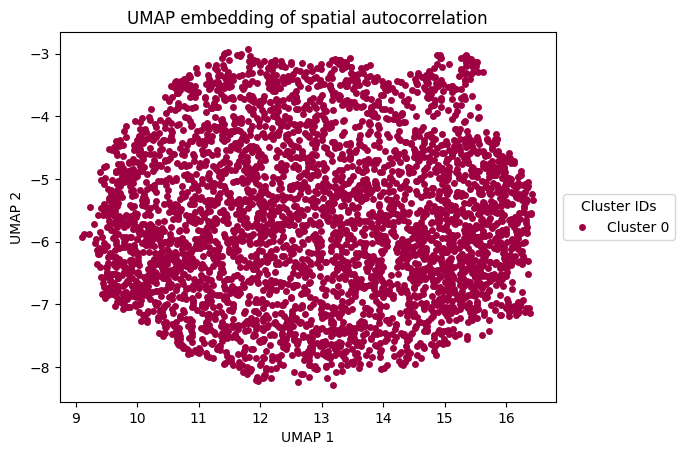

In [9]:
from sklearn.cluster import DBSCAN
import umap

umap_reducer_2d = umap.UMAP(n_components=2, random_state=42)
umap_embedding = umap_reducer_2d.fit_transform(spatial_autocorrelation_matrix.T)

# Clustering with DBSCAN
umap_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(umap_embedding)

# Plot each cluster
unique_labels = np.unique(umap_dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = umap_dbscan.labels_ == k

    xy = umap_embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="none",
        markersize=5,
        label=f"Cluster {k}",
    )  # Removed black edge

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP embedding of spatial autocorrelation")
plt.legend(
    title="Cluster IDs", loc="center left", bbox_to_anchor=(1, 0.5)
)  # Moved legend to the right
plt.show()

In [10]:
umap_clusters = umap_dbscan.fit_predict(umap_embedding)


def get_data_from_cluster(data, cluster_id):
    return data[umap_clusters == cluster_id]


clusters = []

for i in np.unique(umap_clusters):
    cluster = get_data_from_cluster(single_agent_rate_maps[-1], i)
    clusters.append(cluster)

In [11]:
epochs = list(range(0, 45, 5))

scores_dir = os.path.join(single_file_path, "scores")

grid_scores_all_epochs = []
band_scores_all_epochs = []
border_scores_all_epochs = []
for epoch in epochs:
    grid_scores_all_epochs.append(
        np.load(os.path.join(scores_dir, f"score_60_single_agent_epoch_{epoch}.npy"))
    )
    band_scores_all_epochs.append(
        np.load(os.path.join(scores_dir, f"band_scores_single_agent_epoch_{epoch}.npy"))
    )
    border_scores_all_epochs.append(
        np.load(
            os.path.join(scores_dir, f"border_scores_single_agent_epoch_{epoch}.npy")
        )
    )

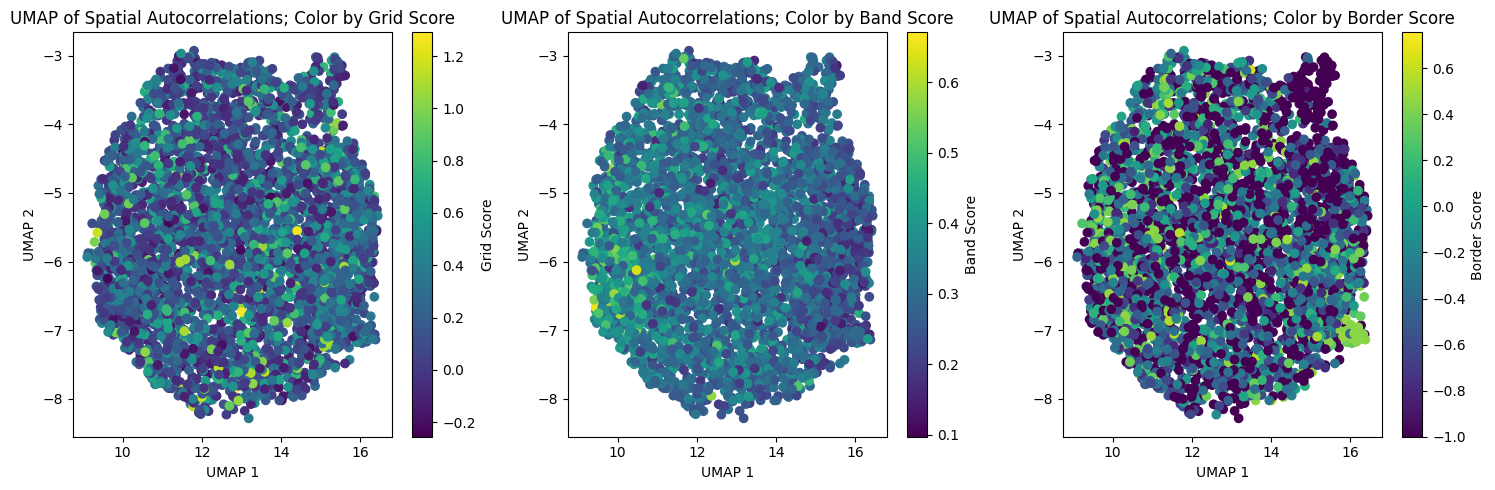

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Grid Scores
sc1 = axs[0].scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=grid_scores_all_epochs[-1],
    cmap="viridis",
)

axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].set_title("UMAP of Spatial Autocorrelations; Color by Grid Score")
fig.colorbar(sc1, ax=axs[0], orientation="vertical", label="Grid Score")

# Plot for Band Scores
sc2 = axs[1].scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=band_scores_all_epochs[-1],
    cmap="viridis",
)
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].set_title("UMAP of Spatial Autocorrelations; Color by Band Score")
fig.colorbar(sc2, ax=axs[1], orientation="vertical", label="Band Score")

# Plot for Border Scores
sc3 = axs[2].scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=border_scores_all_epochs[-1],
    cmap="viridis",
)
axs[2].set_xlabel("UMAP 1")
axs[2].set_ylabel("UMAP 2")
axs[2].set_title("UMAP of Spatial Autocorrelations; Color by Border Score")
fig.colorbar(sc3, ax=axs[2], orientation="vertical", label="Border Score")

plt.tight_layout()
plt.savefig("umap_scores.svg")

### Compute Persistent Homology

In [35]:
cluster_id = 0
neural_points = clusters[cluster_id].reshape(len(clusters[cluster_id]), -1).T
print(neural_points.shape)

(400, 4096)


(400, 2)


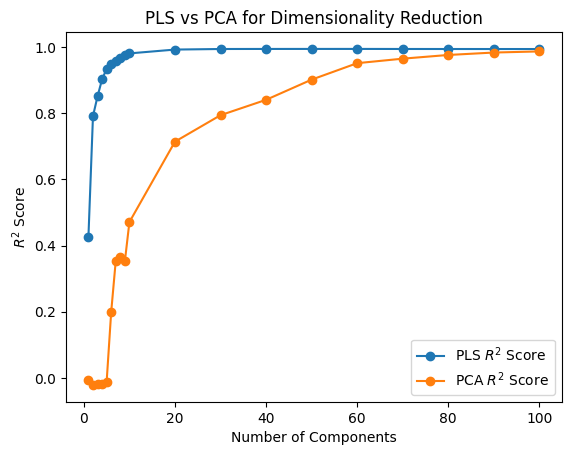

In [108]:
from neurometry.dimension.dimension import (
    evaluate_PCA_with_different_K,
    evaluate_pls_with_different_K,
)

box_width = 2.2
res = 20
bin_edges = np.linspace(-box_width / 2, box_width / 2, res + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x_centers, y_centers = np.meshgrid(bin_centers, bin_centers[::-1])
positions_array = np.stack([x_centers, y_centers], axis=-1)
# Flatten the coordinate array to shape (400, 2)
positions = positions_array.reshape(-1, 2)
print(positions.shape)
X = neural_points
Y = positions
K_values = [i for i in range(1, 10)] + [i for i in range(10, 110, 10)]
pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)
pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)
plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")
plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")
plt.xlabel("Number of Components")
plt.ylabel("$R^2$ Score")
plt.title("PLS vs PCA for Dimensionality Reduction")
plt.legend();

In [110]:
neural_points_pca = pca_transformed_X[9]

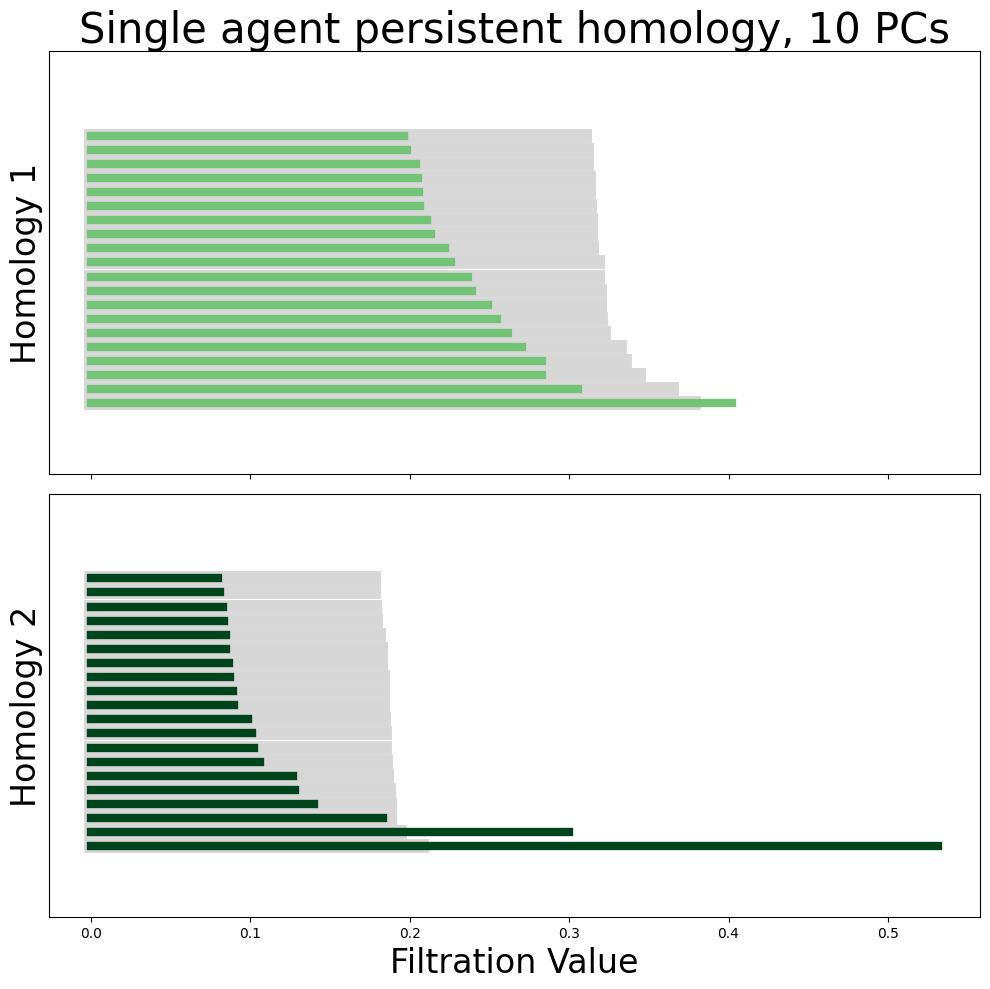

In [111]:
from neurometry.topology.persistent_homology import compute_diagrams_shuffle

module_diagrams = compute_diagrams_shuffle(
    neural_points_pca, num_shuffles=100, homology_dimensions=(1, 2)
)

from neurometry.topology.plotting import plot_all_barcodes_with_null

plot_all_barcodes_with_null(
    module_diagrams,
    f"Single agent persistent homology, {neural_points_pca.shape[1]} PCs",
)

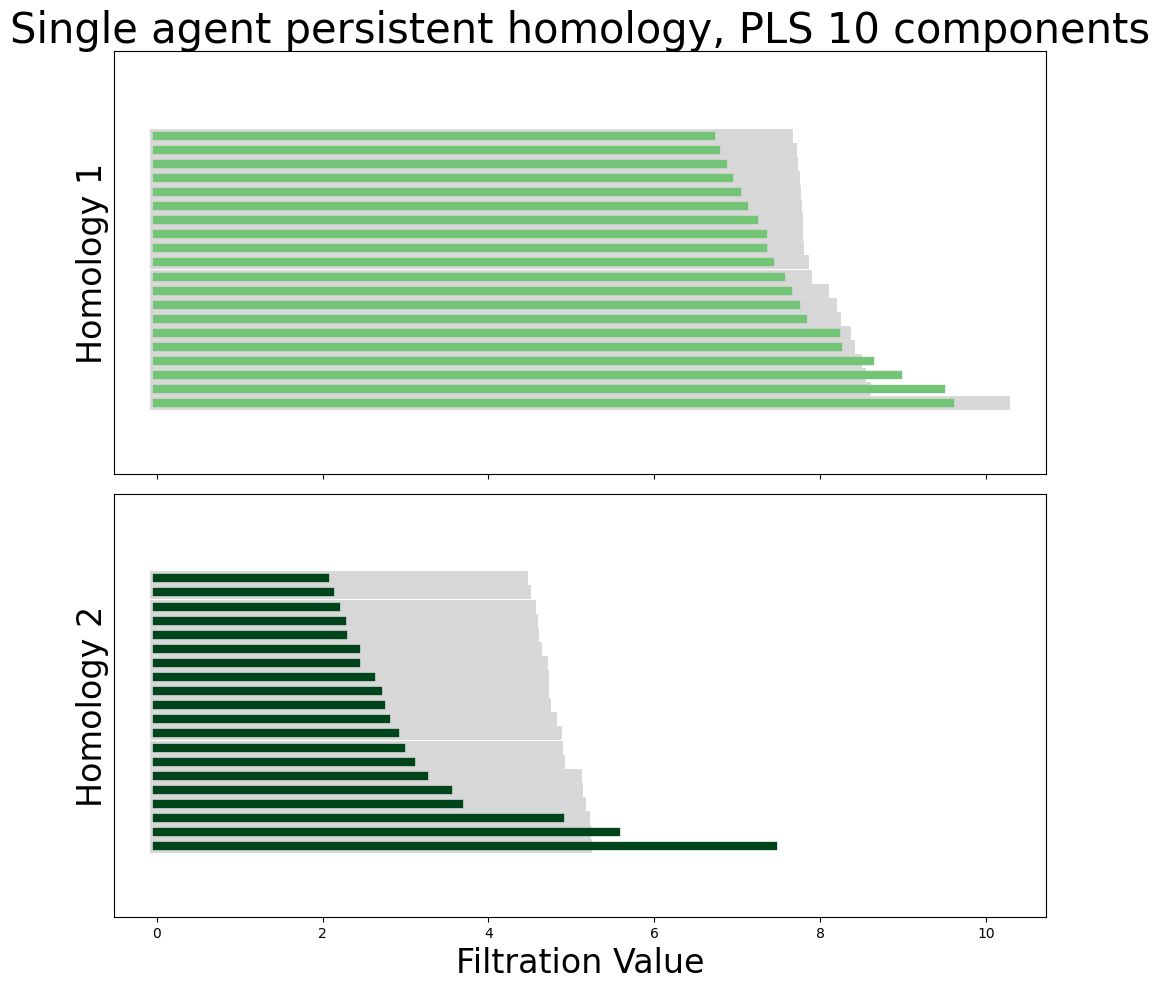

In [81]:
neural_points_pls = pls_transformed_X[9]

module_diagrams_pls = compute_diagrams_shuffle(
    neural_points_pls, num_shuffles=100, homology_dimensions=(1, 2)
)

plot_all_barcodes_with_null(
    module_diagrams_pls,
    f"Single agent persistent homology, PLS {neural_points_pls.shape[1]} components",
)

In [162]:
import neurometry.datasets.synthetic as synthetic

num_points = representations[0].shape[0]
embedding_dim = representations[0].shape[1]

torus_task_points = synthetic.hypertorus(intrinsic_dim=2, num_points=num_points)

_, torus_points = synthetic.synthetic_neural_manifold(
    points=torus_task_points,
    encoding_dim=embedding_dim,
    nonlinearity="linear",
)

norm_torus_points = torus_points / np.linalg.norm(torus_points, axis=1)[:, None]

WARNING! Poisson spikes not generated: mean must be non-negative
noise level: 7.07%


In [192]:
from neurometry.topology.persistent_homology import compute_persistence_diagrams

diagrams = compute_persistence_diagrams(
    [*representations, norm_torus_points],
    homology_dimensions=(1, 2),
)

representations_diagrams = diagrams[:-1]
torus_diagram = diagrams[-1]


from neurometry.topology.pd_distances import compare_representations_to_references

distances_to_torus = compare_representations_to_references(
    representations_diagrams, torus_diagram, metric="landscape"
)

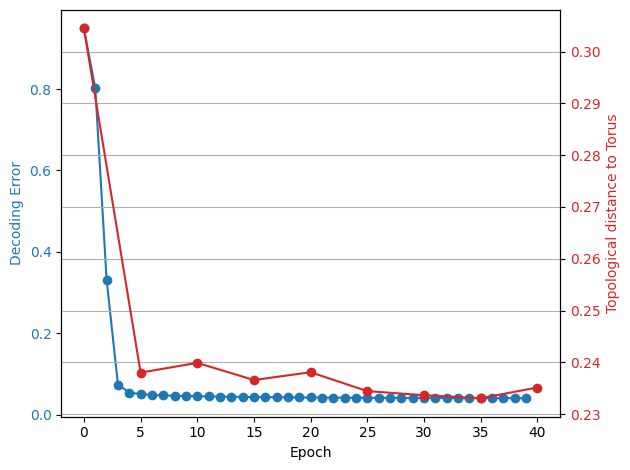

In [201]:
fig, ax1 = plt.subplots()

x1 = np.arange(0, 40)
y1 = decoding_error_aggregated[:40]

# Plot Error
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Decoding Error", color=color)
ax1.plot(x1, y1, color=color, marker="o")
ax1.tick_params(axis="y", labelcolor=color)

x2 = np.arange(0, 45, 5)
y2 = distances_to_torus[:9]

# Plot Topological distance to Torus
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Topological distance to Torus", color=color)
ax2.plot(x2, y2, color=color, marker="o")
ax2.tick_params(axis="y", labelcolor=color)


fig.tight_layout()
plt.grid()
plt.show()

## Dual-Agent Representations

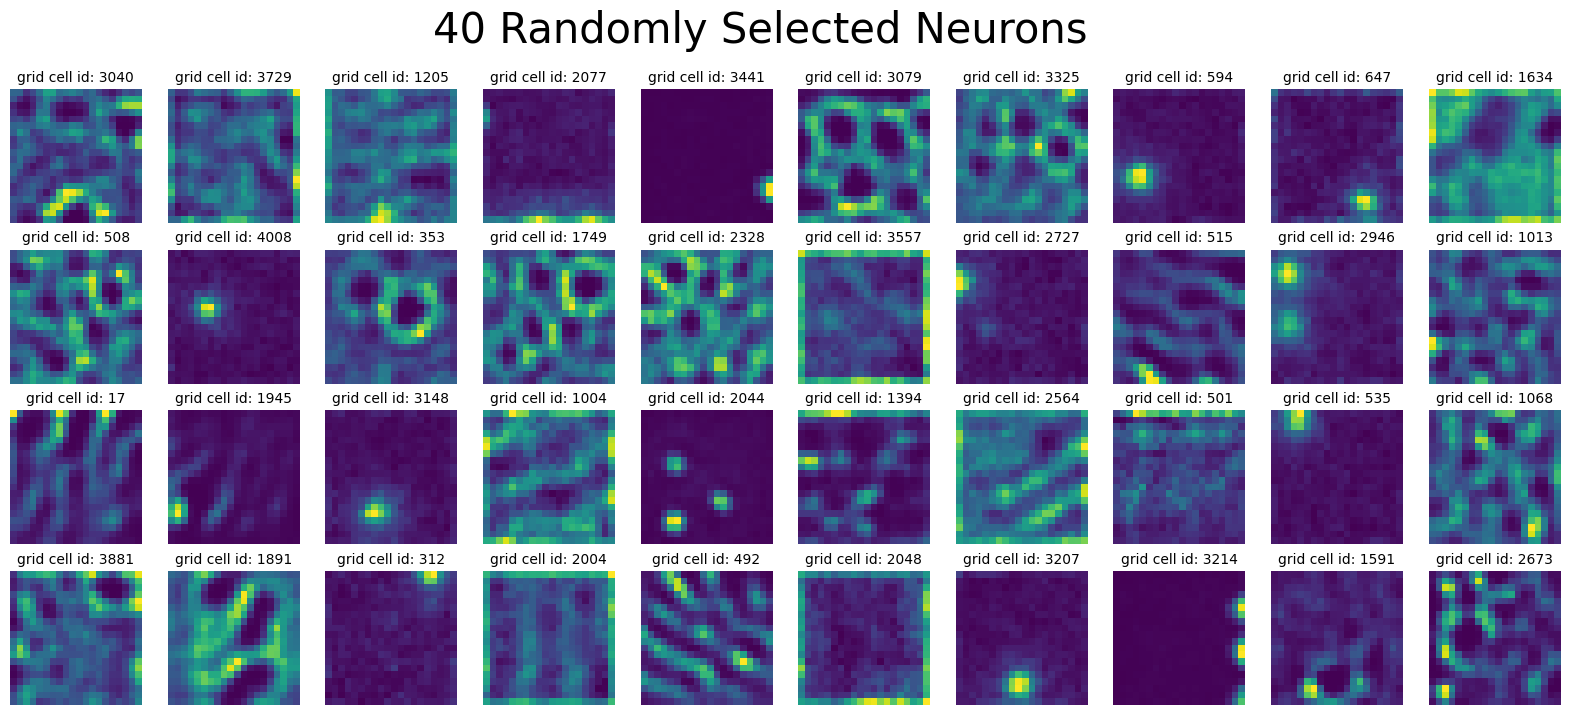

In [100]:
parent_dir = path
dual_model_folder = "Dual agent path integration disjoint PCs/Seed 1 weight decay 1e-06"
dual_model_parameters = "steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_1e-06"
dual_file_path = os.path.join(parent_dir, dual_model_folder, dual_model_parameters)


epochs = [*list(range(0, 100, 5)), "final"]

(
    dual_agent_activations,
    dual_agent_rate_maps,
    dual_agent_state_points,
) = load_activations(epochs, dual_file_path, version="dual", verbose=False)


plot_rate_map(
    None,
    40,
    dual_agent_activations[-1],
    title=f"{num_plots} Randomly Selected Neurons",
)

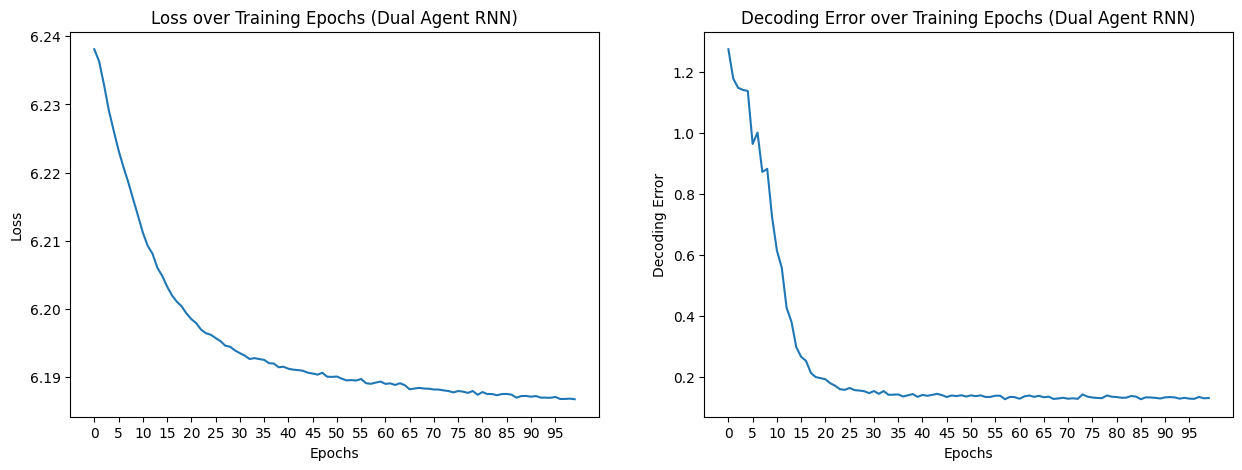

In [179]:
loss_path = os.path.join(
    parent_dir, dual_model_folder, dual_model_parameters, "loss.npy"
)
loss = np.load(loss_path)
loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)

decoding_error_path = os.path.join(
    parent_dir, dual_model_folder, dual_model_parameters, "decoding_error.npy"
)

decoding_error = np.load(decoding_error_path)
decoding_error_aggregated = np.mean(decoding_error.reshape(-1, 2), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

epochs = list(range(0, 100))
axs[0].plot(epochs, loss_aggregated)
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Training Epochs (Dual Agent RNN)")

axs[0].set_xticks(epochs[::5])

axs[1].plot(epochs, decoding_error_aggregated)
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Decoding Error")
axs[1].set_title("Decoding Error over Training Epochs (Dual Agent RNN)")

axs[1].set_xticks(epochs[::5]);

In [101]:
dual_representations = []

for rep in dual_agent_rate_maps:
    points = rep.T
    norm_points = points / np.linalg.norm(points, axis=1)[:, None]
    dual_representations.append(norm_points)

In [102]:
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width = 2.2
box_height = 2.2
res = 20
coord_range = ((-box_width / 2, box_width / 2), (-box_height / 2, box_height / 2))

masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)


rate_maps = [rm.mean(axis=-1) for rm in dual_agent_activations]

spatial_autocorrelations = get_spatial_autocorrelation(
    dual_file_path, rate_maps[-1], scorer
)

Computing spatial auto-correlation...


100%|██████████| 4096/4096 [00:26<00:00, 155.65it/s]


In [103]:
dual_spatial_autocorrelation_matrix = vectorized_spatial_autocorrelation_matrix(
    spatial_autocorrelations
)

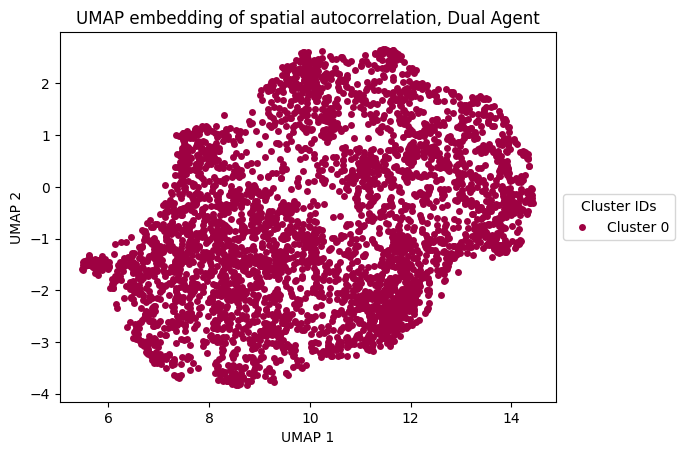

In [104]:
from sklearn.cluster import DBSCAN
import umap

umap_reducer_2d = umap.UMAP(n_components=2, random_state=42)
dual_umap_embedding = umap_reducer_2d.fit_transform(
    dual_spatial_autocorrelation_matrix.T
)

# Clustering with DBSCAN
dual_umap_dbscan = DBSCAN(eps=0.5, min_samples=5).fit(dual_umap_embedding)

# Plot each cluster
unique_labels = np.unique(dual_umap_dbscan.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = dual_umap_dbscan.labels_ == k

    xy = dual_umap_embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="none",
        markersize=5,
        label=f"Cluster {k}",
    )  # Removed black edge

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP embedding of spatial autocorrelation, Dual Agent")
plt.legend(
    title="Cluster IDs", loc="center left", bbox_to_anchor=(1, 0.5)
)  # Moved legend to the right
plt.show()

In [204]:
umap_clusters = umap_dbscan.fit_predict(dual_umap_embedding)


def get_data_from_cluster(data, cluster_id):
    return data[umap_clusters == cluster_id]


clusters = []

for i in np.unique(umap_clusters):
    cluster = get_data_from_cluster(dual_agent_rate_maps[-1], i)
    clusters.append(cluster)

cluster_id = 0
neural_points = clusters[cluster_id].reshape(len(clusters[cluster_id]), -1).T
print(neural_points.shape)

(400, 4096)


In [113]:
epochs = list(range(0, 45, 5))

scores_dir = os.path.join(dual_file_path, "scores")

grid_scores_all_epochs = []
band_scores_all_epochs = []
border_scores_all_epochs = []
for epoch in epochs:
    grid_scores_all_epochs.append(
        np.load(os.path.join(scores_dir, f"score_60_dual_agent_epoch_{epoch}.npy"))
    )
    band_scores_all_epochs.append(
        np.load(os.path.join(scores_dir, f"band_scores_dual_agent_epoch_{epoch}.npy"))
    )
    border_scores_all_epochs.append(
        np.load(os.path.join(scores_dir, f"border_scores_dual_agent_epoch_{epoch}.npy"))
    )

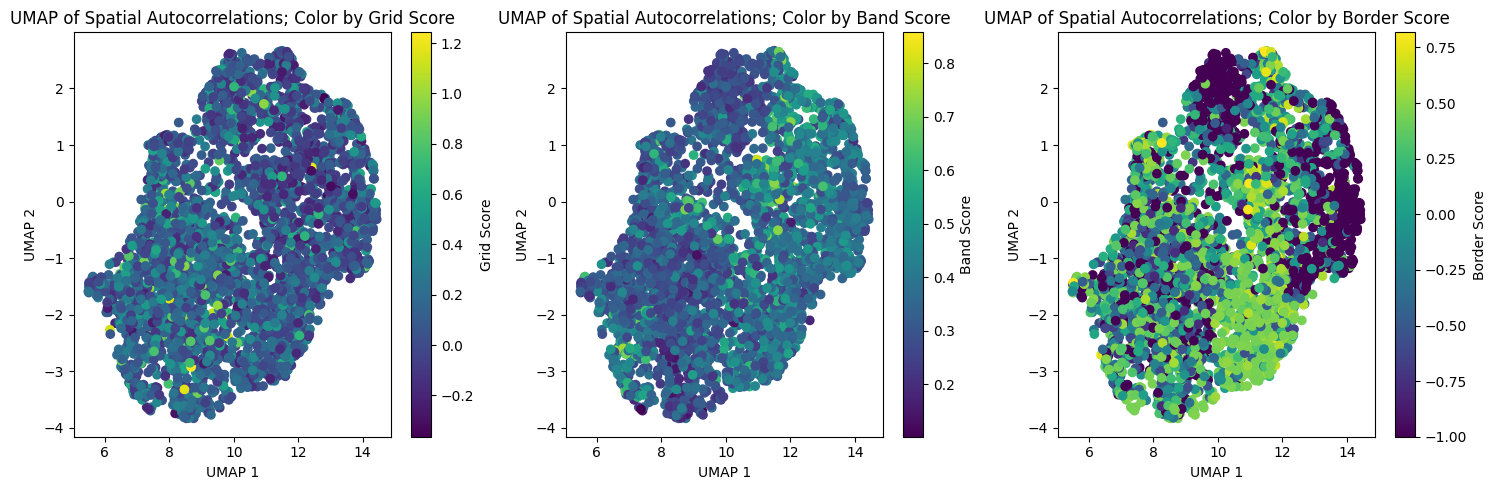

In [114]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Grid Scores
sc1 = axs[0].scatter(
    dual_umap_embedding[:, 0],
    dual_umap_embedding[:, 1],
    c=grid_scores_all_epochs[-1],
    cmap="viridis",
)

axs[0].set_xlabel("UMAP 1")
axs[0].set_ylabel("UMAP 2")
axs[0].set_title("UMAP of Spatial Autocorrelations; Color by Grid Score")
fig.colorbar(sc1, ax=axs[0], orientation="vertical", label="Grid Score")

# Plot for Band Scores
sc2 = axs[1].scatter(
    dual_umap_embedding[:, 0],
    dual_umap_embedding[:, 1],
    c=band_scores_all_epochs[-1],
    cmap="viridis",
)
axs[1].set_xlabel("UMAP 1")
axs[1].set_ylabel("UMAP 2")
axs[1].set_title("UMAP of Spatial Autocorrelations; Color by Band Score")
fig.colorbar(sc2, ax=axs[1], orientation="vertical", label="Band Score")

# Plot for Border Scores
sc3 = axs[2].scatter(
    dual_umap_embedding[:, 0],
    dual_umap_embedding[:, 1],
    c=border_scores_all_epochs[-1],
    cmap="viridis",
)
axs[2].set_xlabel("UMAP 1")
axs[2].set_ylabel("UMAP 2")
axs[2].set_title("UMAP of Spatial Autocorrelations; Color by Border Score")
fig.colorbar(sc3, ax=axs[2], orientation="vertical", label="Border Score")

plt.tight_layout()

(400, 2)


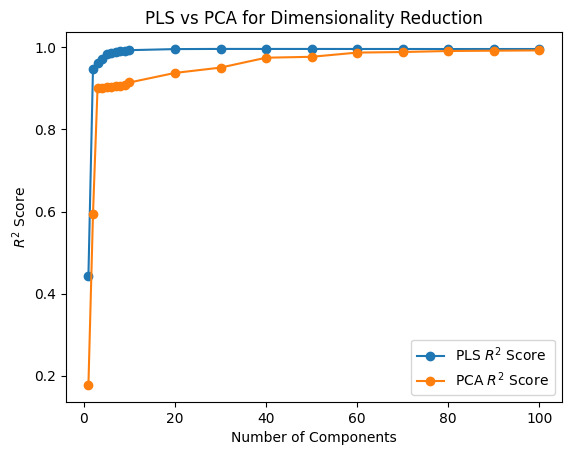

In [115]:
from neurometry.dimension.dimension import (
    evaluate_PCA_with_different_K,
    evaluate_pls_with_different_K,
)

box_width = 2.2
res = 20
bin_edges = np.linspace(-box_width / 2, box_width / 2, res + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
x_centers, y_centers = np.meshgrid(bin_centers, bin_centers[::-1])
positions_array = np.stack([x_centers, y_centers], axis=-1)
# Flatten the coordinate array to shape (400, 2)
positions = positions_array.reshape(-1, 2)
print(positions.shape)
X = neural_points
Y = positions
K_values = [i for i in range(1, 10)] + [i for i in range(10, 110, 10)]
pca_r2_scores, pca_transformed_X = evaluate_PCA_with_different_K(X, Y, K_values)
pls_r2_scores, pls_transformed_X = evaluate_pls_with_different_K(X, Y, K_values)
plt.plot(K_values, pls_r2_scores, marker="o", label="PLS $R^2$ Score")
plt.plot(K_values, pca_r2_scores, marker="o", label="PCA $R^2$ Score")
plt.xlabel("Number of Components")
plt.ylabel("$R^2$ Score")
plt.title("PLS vs PCA for Dimensionality Reduction")
plt.legend();

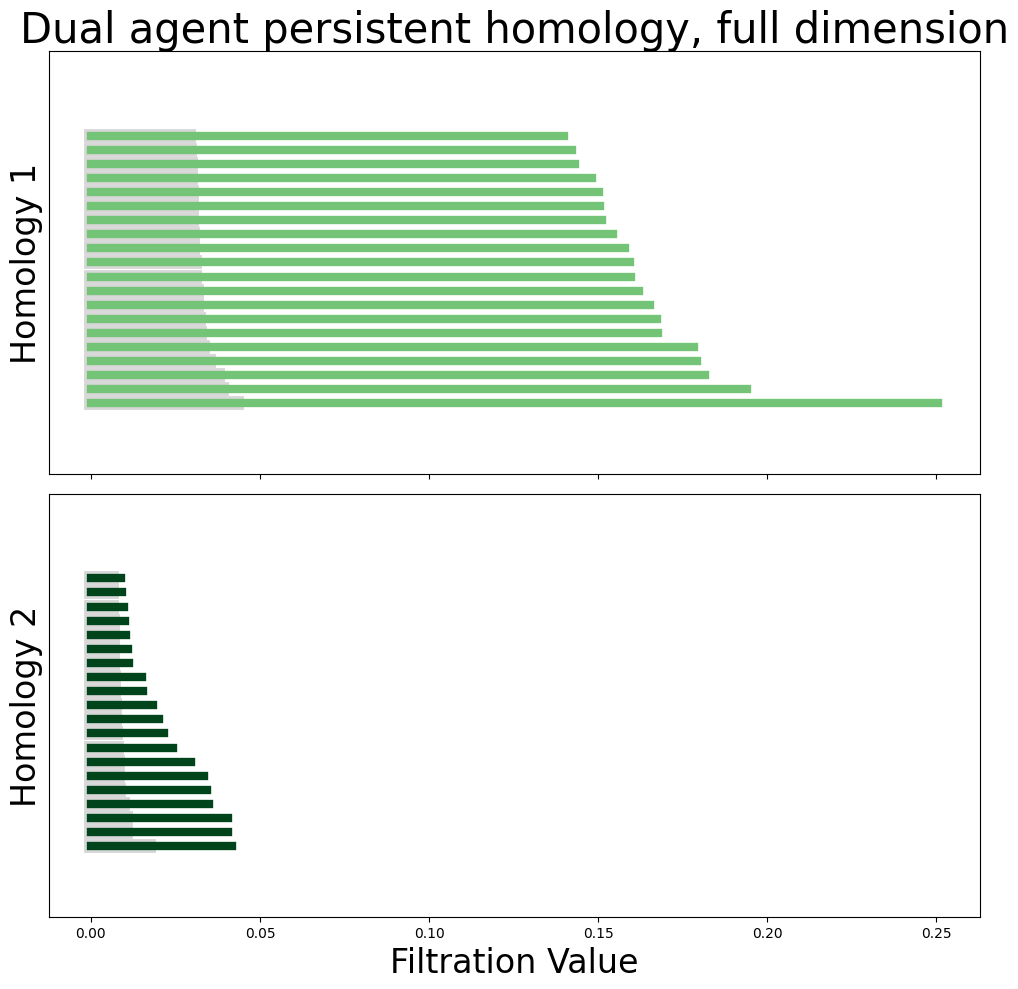

In [206]:
module_diagrams = compute_diagrams_shuffle(
    neural_points, num_shuffles=1000, homology_dimensions=(1, 2)
)

plot_all_barcodes_with_null(
    module_diagrams,
    f"Dual agent persistent homology, full dimension",
)

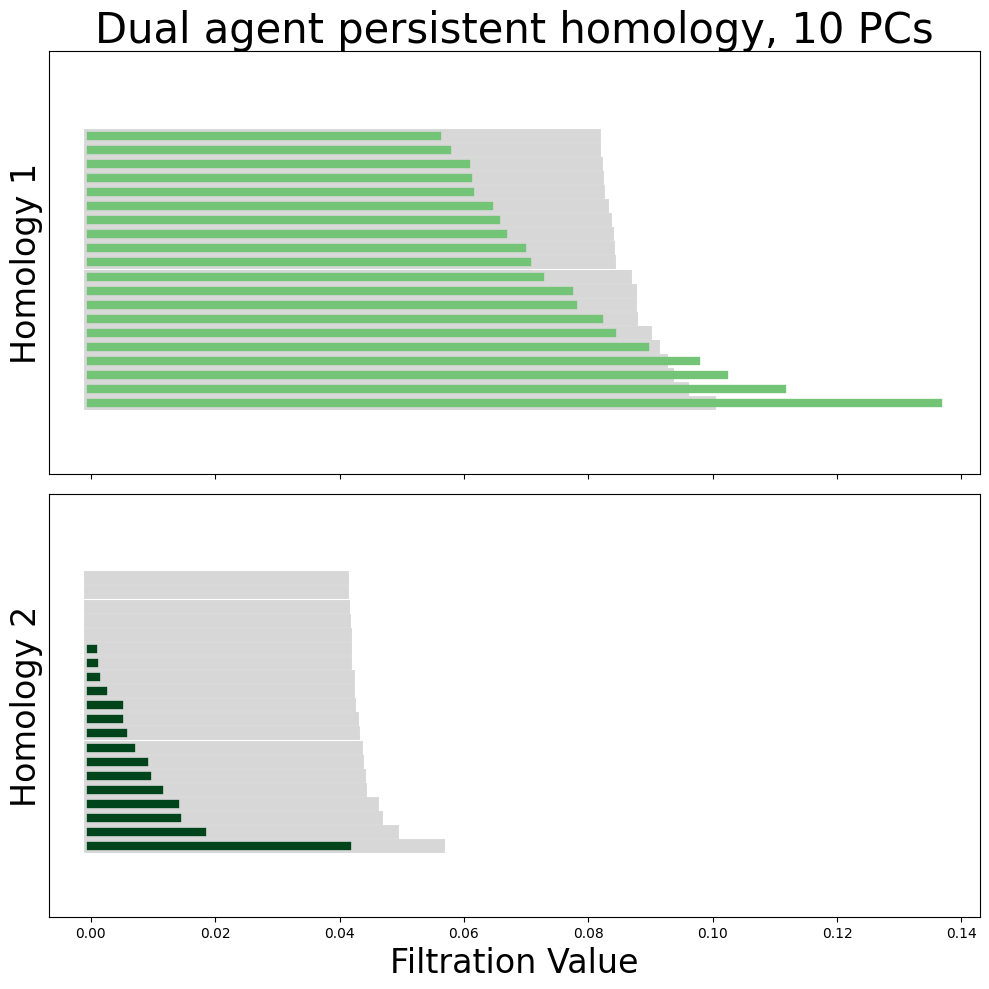

In [116]:
neural_points_pca = pca_transformed_X[9]

module_diagrams = compute_diagrams_shuffle(
    neural_points_pca, num_shuffles=100, homology_dimensions=(1, 2)
)

plot_all_barcodes_with_null(
    module_diagrams,
    f"Dual agent persistent homology, {neural_points_pca.shape[1]} PCs",
)

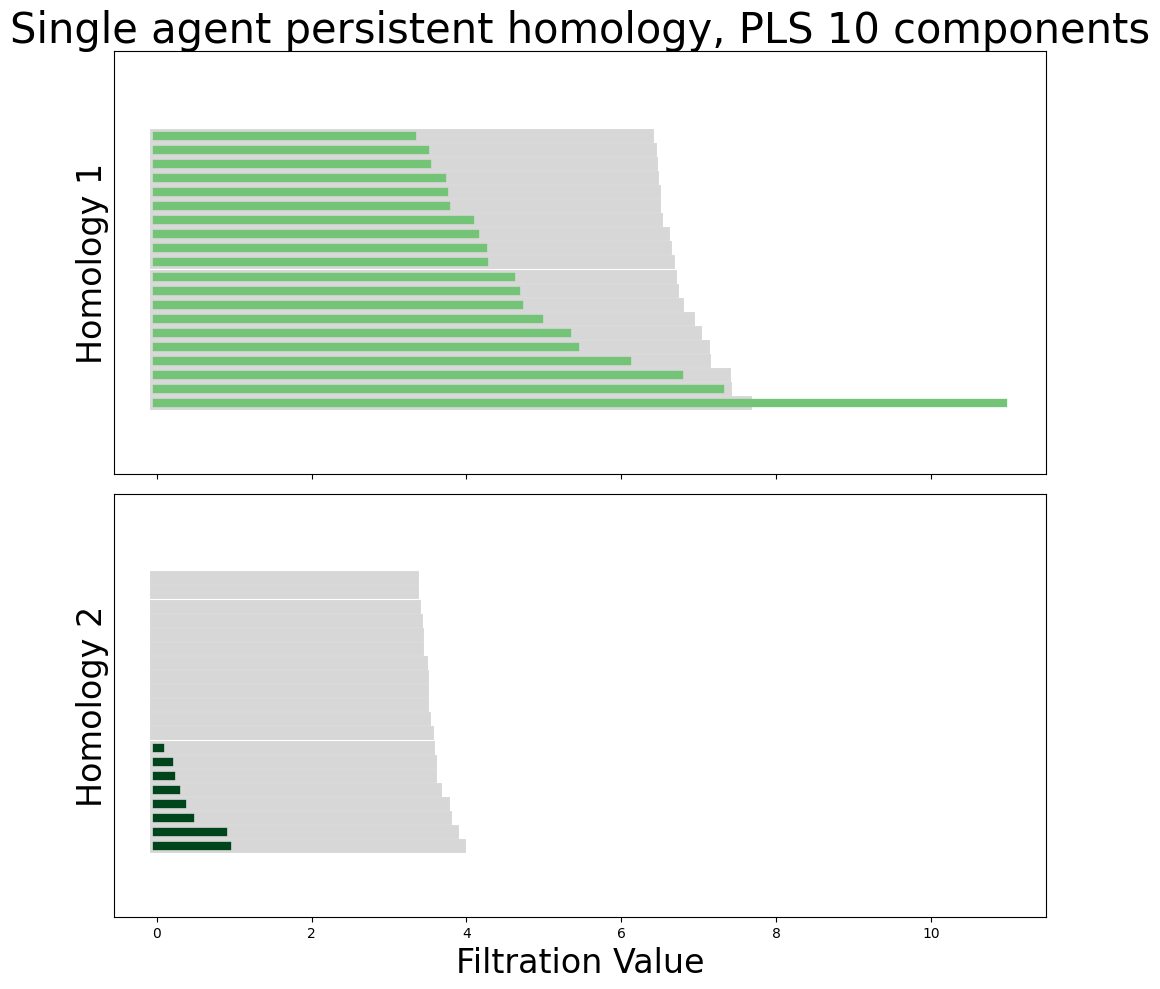

In [117]:
neural_points_pls = pls_transformed_X[9]

module_diagrams_pls = compute_diagrams_shuffle(
    neural_points_pls, num_shuffles=100, homology_dimensions=(1, 2)
)

plot_all_barcodes_with_null(
    module_diagrams_pls,
    f"Single agent persistent homology, PLS {neural_points_pls.shape[1]} components",
)

In [121]:
diags = compute_diagrams_shuffle(
    neural_points_pls, num_shuffles=1, homology_dimensions=(1, 2)
)

In [127]:
import neurometry.datasets.synthetic as synthetic

num_points = dual_representations[0].shape[0]
embedding_dim = dual_representations[0].shape[1]

torus_task_points = synthetic.hypertorus(intrinsic_dim=2, num_points=num_points)

_, torus_points = synthetic.synthetic_neural_manifold(
    points=torus_task_points,
    encoding_dim=embedding_dim,
    nonlinearity="linear",
)

norm_torus_points = torus_points / np.linalg.norm(torus_points, axis=1)[:, None]

WARNING! Poisson spikes not generated: mean must be non-negative
noise level: 7.07%


In [202]:
from neurometry.topology.persistent_homology import compute_persistence_diagrams

diagrams = compute_persistence_diagrams(
    [*dual_representations, norm_torus_points],
    homology_dimensions=(1, 2),
)

representations_diagrams = diagrams[:-1]
torus_diagram = diagrams[-1]


from neurometry.topology.pd_distances import compare_representations_to_references

distances_to_torus = compare_representations_to_references(
    representations_diagrams, torus_diagram, metric="landscape"
)

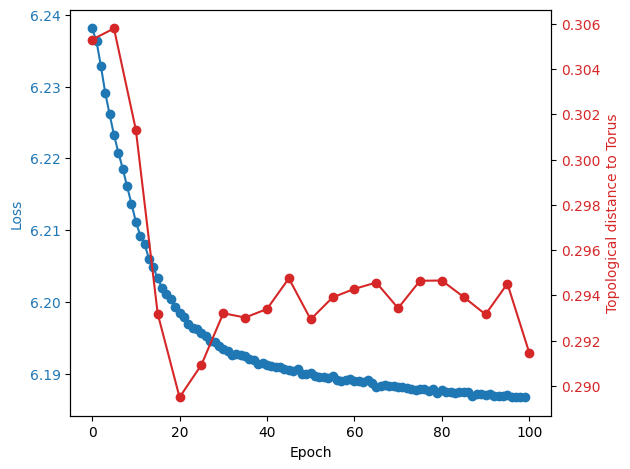

In [189]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)
x1 = np.arange(0, 100)
y1 = loss_aggregated

# Plot Loss
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color)
ax1.plot(x1, y1, color=color, marker="o")
ax1.tick_params(axis="y", labelcolor=color)

x2 = np.arange(0, 105, 5)
y2 = distances_to_torus

# Plot Topological distance to Torus
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Topological distance to Torus", color=color)
ax2.plot(x2, y2, color=color, marker="o")
ax2.tick_params(axis="y", labelcolor=color)

# Show the plot
fig.tight_layout()  # To ensure the y-labels do not overlap
plt.grid()
plt.show()

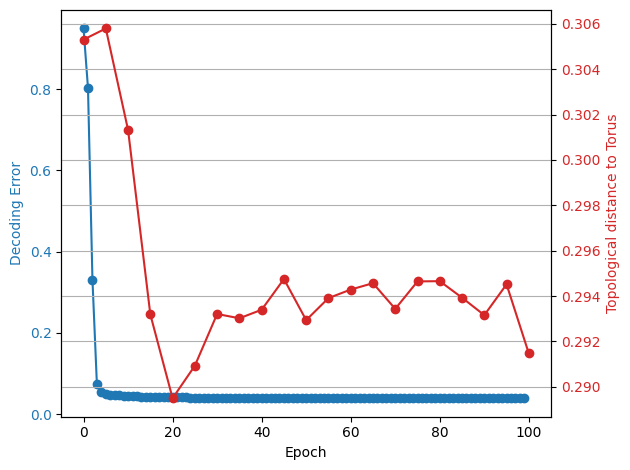

In [203]:
fig, ax1 = plt.subplots()

loss_aggregated = np.mean(loss.reshape(-1, 1000), axis=1)
x1 = np.arange(0, 100)
y1 = decoding_error_aggregated

# Plot Error
color = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Decoding Error", color=color)
ax1.plot(x1, y1, color=color, marker="o")
ax1.tick_params(axis="y", labelcolor=color)

x2 = np.arange(0, 105, 5)
y2 = distances_to_torus

# Plot Topological distance to Torus
ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Topological distance to Torus", color=color)
ax2.plot(x2, y2, color=color, marker="o")
ax2.tick_params(axis="y", labelcolor=color)

# Show the plot
fig.tight_layout()  # To ensure the y-labels do not overlap
plt.grid()
plt.show()